In [1]:
import numpy as np
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Proposta de modelo para producao de celulase
# Angarita et al. 2015

# Experimental data
# 10% solidos e 10FPU/g   [tempo G G2 X]
dados = np.array([
    [1, 4.30, 0.2295, 2.2004],
    [2, 6.83, 0.2981, 3.2317],
    [6, 15.05, 0.4533, 5.0717],
    [8, 20.49, 0.3853, 4.6835],
    [12, 21.02, 0.5157, 5.6440],
    [24, 23.31, 0.4363, 9.6220],
    [48, 35.19, 0.7423, 8.1657],
    [72, 37.86, 0.5667, 7.3837],
    [96, 38.5,  0.3060, 7.9050]
])

# 15% solidos e 10FPU/g Xilose 10 g/L [tempo G G2 X]
dados1 = np.array([
    [1, 6.32, 0.00, 9.91],
    [2, 9.64, 0.00, 10.84],
    [6, 18.84, 0.00, 13.33],
    [12, 28.31, 0.73, 15.22],
    [24, 27.93, 0.72, 19.69],
    [48, 51.82, 1.71, 17.71],
    [72, 57.96, 1.92, 17.81]
])

# Set data for the model
S0 = 100              # Solid loading (Pretreated sugarcane straw)
Cellulose = 0.66         # Cellulose content (0-1, dimensionless)
Hemicellulose = 0.083    # Hemicellulose content (0-1, dimensionless)
Lignin = 0.257           # Lignin content (0-1, dimensionless)
Glucose = 0              # Glucose concentration (g/L)
Cellobiose = 0           # Cellobiose concentration (g/L)
Xylose = 0               # Xylose concentration (g/L)

alfa = 1.0
E_T = 0.175              # Total enzyme concentration (g/L)

# Parameters 
k_1r = 0.177
k_2r = 8.81
k_3r = 201.0
# k_4r = 16.34
k_4r = 1.634
k_11G2 = 0.402
k_11G = 2.71
k_11X = 2.15
k_21G2 = 119.6
k_21G = 4.69
k_21X = 0.095
k_3M = 26.6
k_31G = 11.06
k_31X = 1.023
k_41G2 = 16.25
k_41G = 4.0
k_41X = 154.0

k_ad = 7.16
E_max = 8.32

def enzyme(xx, S):
    E_F = xx[0]
    E_B = E_T - E_F
    return [E_max * k_ad * E_F / (1 + k_ad * E_F) - E_B / S]

# Solve for E_F and E_B
xx0 = [0.5]
S = S0
E_F = fsolve(enzyme, xx0, args=(S))[0]
E_B = E_T - E_F

# Initial conditions
t0 = 0           # Initial time (h)
himp = 1.0       # Print interval (for plotting)
tn = 96      # Final time (h)
t_span = (t0, tn)
t_eval = np.arange(t0, tn + himp, himp)
Lig = Lignin * S0

y0 = [
    S0 * Cellulose,  # C: Cellulose
    Cellobiose,      # G2: Cellobiose
    Glucose,         # G: Glucose
    S0 * Hemicellulose,  # H: Hemicellulose
    Xylose,          # X: Xylose
    S0               # S: Biomass
]

def chemres(t, y):
    C, G2, G, H, X, S = y
    R_S = alfa * S / S0
    r1 = k_1r * (E_B * C / S) * R_S * S / (1 + G2 / k_11G2 + G / k_11G + X / k_11X)
    r2 = k_2r * (E_B * C / S) * R_S * S / (1 + G2 / k_21G2 + G / k_21G + X / k_21X)
    r3 = k_3r * E_F * G2 / (k_3M * (1 + G / k_31G + X / k_31X) + G2)
    r4 = k_4r * (E_B * H / S) * R_S * S / (1 + G2 / k_41G2 + G / k_41G + X / k_41X)
    dC = -r1 - r2
    dG2 = 1.053 * r1 - r3
    dG = 1.111 * r2 + 1.053 * r3
    dH = -r4
    dX = 1.136 * r4
    dS = dC + dH  # S = C + H + Lig, so dS = dC + dH
    return [dC, dG2, dG, dH, dX, dS]

# Integrate the system of equations
sol = solve_ivp(chemres, t_span, y0, t_eval=t_eval, method='BDF')

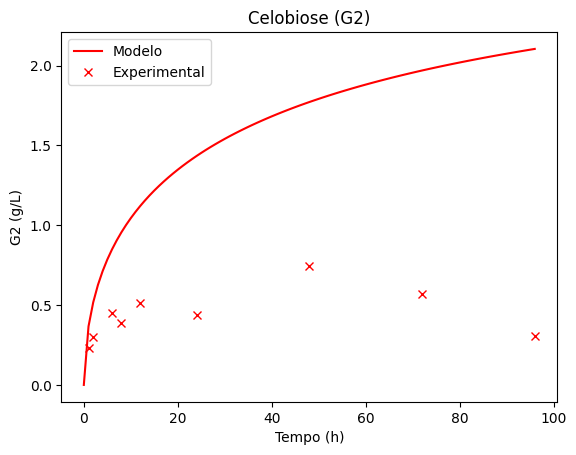

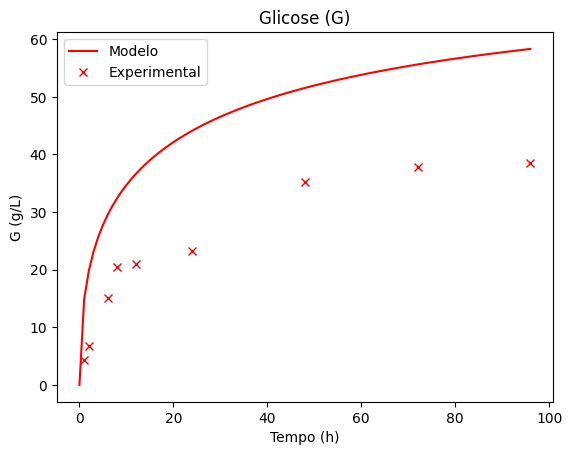

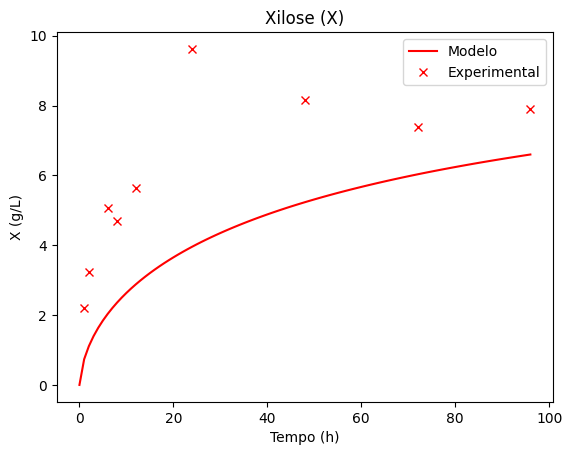

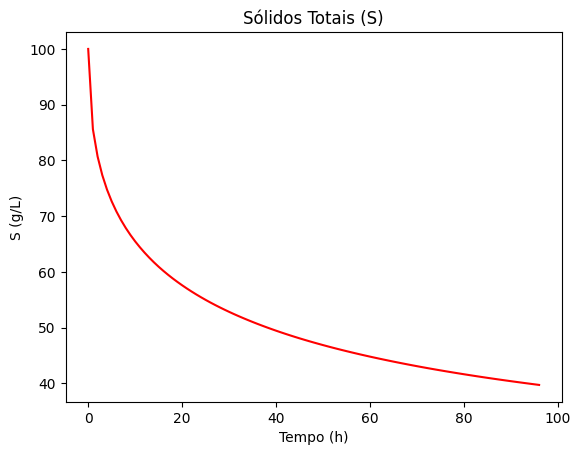

In [2]:
# Plotando as variáveis
plt.figure(0)
plt.plot(sol.t, sol.y[1], 'r', label='Modelo')
plt.plot(dados[:, 0], dados[:, 2], 'xr', label='Experimental')
plt.title("Celobiose (G2)")
plt.xlabel('Tempo (h)')
plt.ylabel('G2 (g/L)')
plt.legend()

plt.figure(1)
plt.plot(sol.t, sol.y[2], 'r', label='Modelo')
plt.plot(dados[:, 0], dados[:, 1], 'xr', label='Experimental')
plt.title("Glicose (G)")
plt.xlabel('Tempo (h)')
plt.ylabel('G (g/L)')
plt.legend()

plt.figure(2)
plt.plot(sol.t, sol.y[4], 'r', label='Modelo')
plt.plot(dados[:, 0], dados[:, 3], 'xr', label='Experimental')
plt.title("Xilose (X)")
plt.xlabel('Tempo (h)')
plt.ylabel('X (g/L)')
plt.legend()

plt.figure(3)
plt.plot(sol.t, sol.y[5], 'r')
plt.title("Sólidos Totais (S)")
plt.xlabel('Tempo (h)')
plt.ylabel('S (g/L)')

plt.show()

# Modelo de Machine Learning para Ajuste dos Dados Experimentais

Vamos criar um modelo de regressão (Random Forest) para ajustar as curvas experimentais de Celobiose (G2), Glicose (G) e Xilose (X) em função do tempo, utilizando os dados experimentais disponíveis.

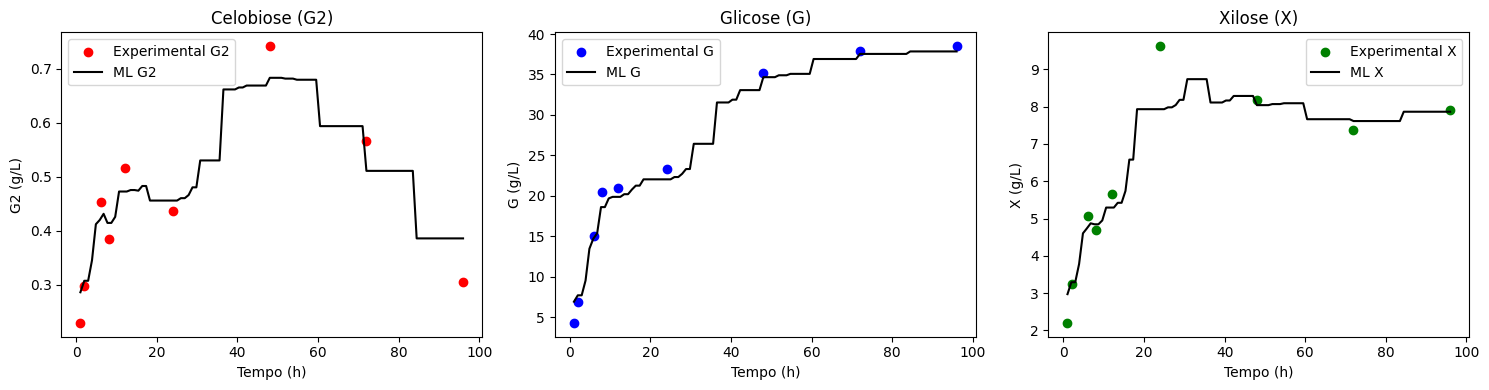

In [3]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# Dados experimentais
t_exp = dados[:, 0].reshape(-1, 1)
G_exp = dados[:, 1]
G2_exp = dados[:, 2]
X_exp = dados[:, 3]

# Treinando modelos para cada variável
rf_g = RandomForestRegressor(n_estimators=100, random_state=42)
rf_g2 = RandomForestRegressor(n_estimators=100, random_state=42)
rf_x = RandomForestRegressor(n_estimators=100, random_state=42)

rf_g.fit(t_exp, G_exp)
rf_g2.fit(t_exp, G2_exp)
rf_x.fit(t_exp, X_exp)

# Previsão para o mesmo intervalo de tempo
t_pred = np.linspace(t_exp.min(), t_exp.max(), 100).reshape(-1, 1)
G_pred = rf_g.predict(t_pred)
G2_pred = rf_g2.predict(t_pred)
X_pred = rf_x.predict(t_pred)

# Plotando as curvas
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.scatter(t_exp, G2_exp, color='red', label='Experimental G2')
plt.plot(t_pred, G2_pred, color='black', label='ML G2')
plt.title('Celobiose (G2)')
plt.xlabel('Tempo (h)')
plt.ylabel('G2 (g/L)')
plt.legend()

plt.subplot(1, 3, 2)
plt.scatter(t_exp, G_exp, color='blue', label='Experimental G')
plt.plot(t_pred, G_pred, color='black', label='ML G')
plt.title('Glicose (G)')
plt.xlabel('Tempo (h)')
plt.ylabel('G (g/L)')
plt.legend()

plt.subplot(1, 3, 3)
plt.scatter(t_exp, X_exp, color='green', label='Experimental X')
plt.plot(t_pred, X_pred, color='black', label='ML X')
plt.title('Xilose (X)')
plt.xlabel('Tempo (h)')
plt.ylabel('X (g/L)')
plt.legend()

plt.tight_layout()
plt.show()

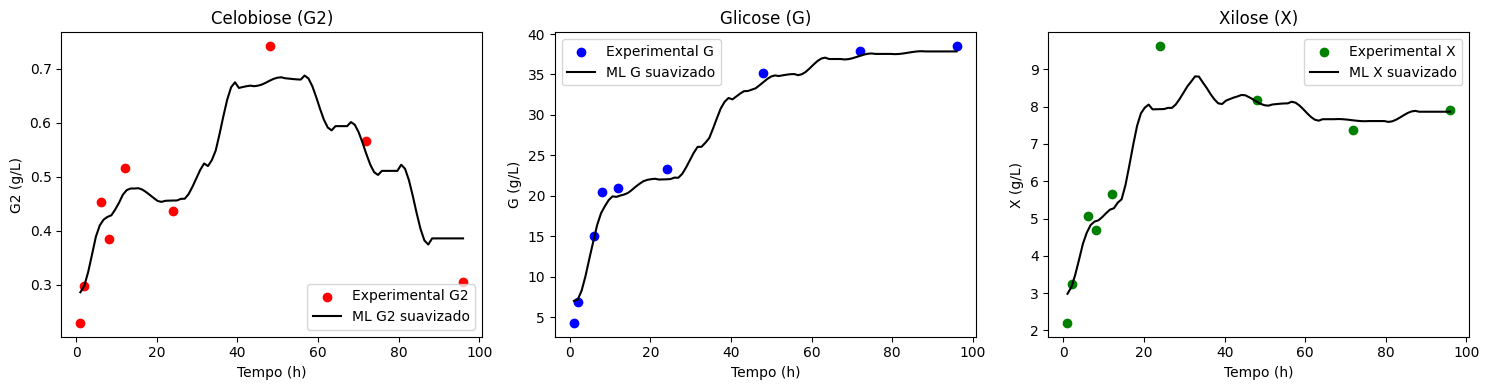

In [4]:
from scipy.signal import savgol_filter

# Suavizando as curvas preditas
G2_pred_smooth = savgol_filter(G2_pred, window_length=9, polyorder=3)
G_pred_smooth = savgol_filter(G_pred, window_length=9, polyorder=3)
X_pred_smooth = savgol_filter(X_pred, window_length=9, polyorder=3)

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.scatter(t_exp, G2_exp, color='red', label='Experimental G2')
plt.plot(t_pred, G2_pred_smooth, color='black', label='ML G2 suavizado')
plt.title('Celobiose (G2)')
plt.xlabel('Tempo (h)')
plt.ylabel('G2 (g/L)')
plt.legend()

plt.subplot(1, 3, 2)
plt.scatter(t_exp, G_exp, color='blue', label='Experimental G')
plt.plot(t_pred, G_pred_smooth, color='black', label='ML G suavizado')
plt.title('Glicose (G)')
plt.xlabel('Tempo (h)')
plt.ylabel('G (g/L)')
plt.legend()

plt.subplot(1, 3, 3)
plt.scatter(t_exp, X_exp, color='green', label='Experimental X')
plt.plot(t_pred, X_pred_smooth, color='black', label='ML X suavizado')
plt.title('Xilose (X)')
plt.xlabel('Tempo (h)')
plt.ylabel('X (g/L)')
plt.legend()

plt.tight_layout()
plt.show()

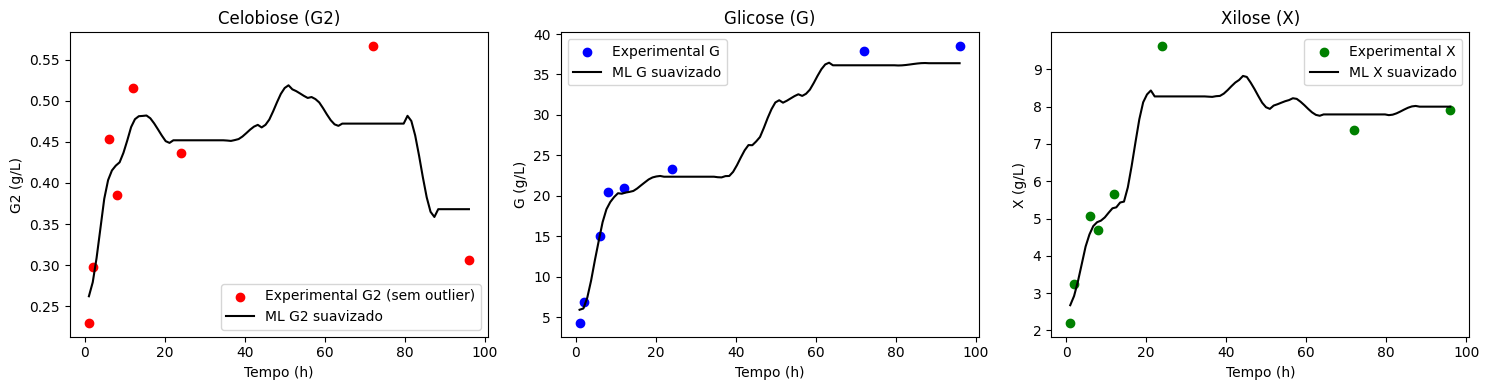

In [5]:
# Remover o outlier de G2 acima de 0.7
mask = dados[:,2] <= 0.7
t_exp_f = dados[mask, 0].reshape(-1, 1)
G_exp_f = dados[mask, 1]
G2_exp_f = dados[mask, 2]
X_exp_f = dados[mask, 3]

# Treinar novamente os modelos
rf_g2_f = RandomForestRegressor(n_estimators=100, random_state=42)
rf_g_f = RandomForestRegressor(n_estimators=100, random_state=42)
rf_x_f = RandomForestRegressor(n_estimators=100, random_state=42)

rf_g2_f.fit(t_exp_f, G2_exp_f)
rf_g_f.fit(t_exp_f, G_exp_f)
rf_x_f.fit(t_exp_f, X_exp_f)

t_pred_f = np.linspace(t_exp_f.min(), t_exp_f.max(), 100).reshape(-1, 1)
G2_pred_f = rf_g2_f.predict(t_pred_f)
G_pred_f = rf_g_f.predict(t_pred_f)
X_pred_f = rf_x_f.predict(t_pred_f)

# Suavizar as curvas
G2_pred_f_smooth = savgol_filter(G2_pred_f, window_length=9, polyorder=3)
G_pred_f_smooth = savgol_filter(G_pred_f, window_length=9, polyorder=3)
X_pred_f_smooth = savgol_filter(X_pred_f, window_length=9, polyorder=3)

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.scatter(t_exp_f, G2_exp_f, color='red', label='Experimental G2 (sem outlier)')
plt.plot(t_pred_f, G2_pred_f_smooth, color='black', label='ML G2 suavizado')
plt.title('Celobiose (G2)')
plt.xlabel('Tempo (h)')
plt.ylabel('G2 (g/L)')
plt.legend()

plt.subplot(1, 3, 2)
plt.scatter(t_exp_f, G_exp_f, color='blue', label='Experimental G')
plt.plot(t_pred_f, G_pred_f_smooth, color='black', label='ML G suavizado')
plt.title('Glicose (G)')
plt.xlabel('Tempo (h)')
plt.ylabel('G (g/L)')
plt.legend()

plt.subplot(1, 3, 3)
plt.scatter(t_exp_f, X_exp_f, color='green', label='Experimental X')
plt.plot(t_pred_f, X_pred_f_smooth, color='black', label='ML X suavizado')
plt.title('Xilose (X)')
plt.xlabel('Tempo (h)')
plt.ylabel('X (g/L)')
plt.legend()

plt.tight_layout()
plt.show()

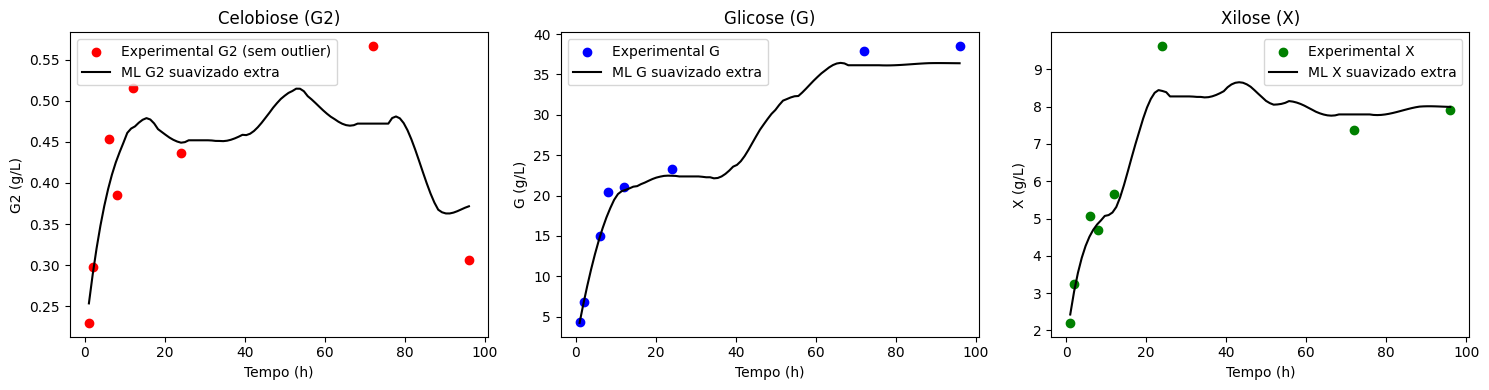

In [6]:
# Suavização extra das curvas (window_length maior)
G2_pred_f_smooth2 = savgol_filter(G2_pred_f, window_length=17, polyorder=3)
G_pred_f_smooth2 = savgol_filter(G_pred_f, window_length=17, polyorder=3)
X_pred_f_smooth2 = savgol_filter(X_pred_f, window_length=17, polyorder=3)

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.scatter(t_exp_f, G2_exp_f, color='red', label='Experimental G2 (sem outlier)')
plt.plot(t_pred_f, G2_pred_f_smooth2, color='black', label='ML G2 suavizado extra')
plt.title('Celobiose (G2)')
plt.xlabel('Tempo (h)')
plt.ylabel('G2 (g/L)')
plt.legend()

plt.subplot(1, 3, 2)
plt.scatter(t_exp_f, G_exp_f, color='blue', label='Experimental G')
plt.plot(t_pred_f, G_pred_f_smooth2, color='black', label='ML G suavizado extra')
plt.title('Glicose (G)')
plt.xlabel('Tempo (h)')
plt.ylabel('G (g/L)')
plt.legend()

plt.subplot(1, 3, 3)
plt.scatter(t_exp_f, X_exp_f, color='green', label='Experimental X')
plt.plot(t_pred_f, X_pred_f_smooth2, color='black', label='ML X suavizado extra')
plt.title('Xilose (X)')
plt.xlabel('Tempo (h)')
plt.ylabel('X (g/L)')
plt.legend()

plt.tight_layout()
plt.show()